# Intrusion Detection using NSL-KDD
This notebook performs preprocessing, training, and evaluation of Random Forest and MLP models.

## 1. Imports

In [11]:
# Data manipulation and handling
import pandas as pd              # For loading and working with tabular data
import numpy as np               # For numerical operations and array manipulation

# Preprocessing tools
from sklearn.preprocessing import OneHotEncoder, StandardScaler   # For encoding categorical features and scaling numeric features
from sklearn.compose import ColumnTransformer                     # For applying different preprocessing steps to different column types

# Model training utilities
from sklearn.model_selection import train_test_split              # For splitting data into training and testing sets
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  
# Metrics for evaluating classification model performance

# Machine learning models
from sklearn.ensemble import RandomForestClassifier               # Random Forest classifier (tree-based ensemble model)
from sklearn.neural_network import MLPClassifier                  # Neural Network classifier (Multi-Layer Perceptron)

# this cell was created with the help of generative AI (ChatGPT)

## 2. Training and Testing Shapes

In [12]:
# Define the official NSL-KDD column names for proper dataset labelling
col_names = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes",
    "land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count",
    "dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate",
    "dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
    "dst_host_srv_rerror_rate","label","difficulty"
]

# Define file paths for NSL-KDD training and testing sets
train_path = "/Users/marconaumov/Documents/S2-ML-Intrusion-Detection_MN/Data/raw/NSL-KDD/KDDTrain+.txt"
test_path  = "/Users/marconaumov/Documents/S2-ML-Intrusion-Detection_MN/Data/raw/NSL-KDD/KDDTest+.txt"

# Load the NSL-KDD dataset into Pandas DataFrames, applying column names
train_df = pd.read_csv(train_path, names=col_names)
test_df  = pd.read_csv(test_path,  names=col_names)

# Display dataset shapes for verification
print("TRAIN SHAPE:", train_df.shape)
print("TEST SHAPE:", test_df.shape)


TRAIN SHAPE: (125973, 43)
TEST SHAPE: (22544, 43)


## 3. Labelling

In [13]:
# Display the distribution of labels in the training dataset
# This helps confirm class balance and identify potential issues such as imbalance
print("\nTRAIN LABEL DISTRIBUTION:")
print(train_df["label"].value_counts())

# Display the distribution of labels in the testing dataset
# Ensures the test set reflects realistic proportions of normal vs attack traffic
print("\nTEST LABEL DISTRIBUTION:")
print(test_df["label"].value_counts())



TRAIN LABEL DISTRIBUTION:
label
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64

TEST LABEL DISTRIBUTION:
label
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       17

In [14]:
# Convert the original multi-class label into a binary label
# "normal" traffic → 0 (benign)
# any other label (attack types) → 1 (malicious)
# This simplifies the classification problem into binary intrusion detection.
train_df["binary_label"] = train_df["label"].apply(lambda x: 0 if x == "normal" else 1)
test_df["binary_label"]  = test_df["label"].apply(lambda x: 0 if x == "normal" else 1)

# Display the count of each class (0 = normal, 1 = attack) in both datasets
# This is useful for understanding dataset balance and informing model evaluation.
train_df["binary_label"].value_counts(), test_df["binary_label"].value_counts()

# this cell was created with the help of generative AI (ChatGPT)

(binary_label
 0    67343
 1    58630
 Name: count, dtype: int64,
 binary_label
 1    12833
 0     9711
 Name: count, dtype: int64)

In [15]:
# Separate features (X) and target labels (y) for training and testing

# Remove the original multi-class label, the difficulty column, 
# and the new binary label from the feature set.
# "binary_label" will be used as the target variable.
X_train = train_df.drop(["label", "difficulty", "binary_label"], axis=1)
y_train = train_df["binary_label"]

# Do the same for the test dataset
X_test  = test_df.drop(["label", "difficulty", "binary_label"], axis=1)
y_test  = test_df["binary_label"]

# this cell was created with the help of generative AI (ChatGPT)

In [16]:
# Identify which columns are categorical and which are numerical

# These three columns contain text-based categories, so they require one-hot encoding.
categorical_cols = ["protocol_type", "service", "flag"]

# All remaining columns are numerical.
# Create a list of every column that is NOT in the categorical list.
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]


## 4. Data Preprocessing

In [17]:
# Create a preprocessing pipeline using ColumnTransformer.
# This allows application of different transformations to numerical and categorical features.

preprocessor = ColumnTransformer(
    transformers=[
        # Apply StandardScaler to all numeric columns
        # This normalises numeric features to have mean 0 and standard deviation 1
        ("num", StandardScaler(), numeric_cols),

        # Apply OneHotEncoder to all categorical columns
        # handle_unknown='ignore' prevents errors if unseen categories appear in the test set
        # sparse_output=False ensures the output is a dense array (easier to work with)
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
    ]
)

# Fit the preprocessing pipeline on the training data and transform it
# This ensures the scaler parameters are learned ONLY from training data
X_train_processed = preprocessor.fit_transform(X_train)

# Apply the same transformation to the test data (no refitting!)
X_test_processed  = preprocessor.transform(X_test)

# this cell was created with the help of generative AI (ChatGPT)

## 5. Random Forest

In [18]:
# Initialise the Random Forest classifier
# n_estimators=150 means the model uses 150 decision trees
# random_state=42 ensures reproducibility of the results
rf = RandomForestClassifier(n_estimators=150, random_state=42)

# Train the Random Forest on the preprocessed training data
rf.fit(X_train_processed, y_train)

# Generate predictions on the preprocessed test data
rf_preds = rf.predict(X_test_processed)

# Print evaluation results
print("=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, rf_preds))        # Overall accuracy
print(classification_report(y_test, rf_preds))              # Precision, recall, f1-score
print(confusion_matrix(y_test, rf_preds))                   # True/false positives/negatives


=== Random Forest ===
Accuracy: 0.7655251951738822
              precision    recall  f1-score   support

           0       0.65      0.97      0.78      9711
           1       0.97      0.61      0.75     12833

    accuracy                           0.77     22544
   macro avg       0.81      0.79      0.76     22544
weighted avg       0.83      0.77      0.76     22544

[[9447  264]
 [5022 7811]]


## 6. Neural Network

In [19]:
# Initialise the neural network (Multi-Layer Perceptron classifier)
# random_state=42 ensures reproducible results
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=200, random_state=42)

# Train the neural network on the preprocessed training data
mlp.fit(X_train_processed, y_train)

# Generate predictions on the preprocessed test data
mlp_preds = mlp.predict(X_test_processed)

# Print evaluation results
print("=== Neural Network ===")
print("Accuracy:", accuracy_score(y_test, mlp_preds))        # Overall accuracy
print(classification_report(y_test, mlp_preds))              # Precision, recall, f1-score
print(confusion_matrix(y_test, mlp_preds))                   # Confusion matrix


=== Neural Network ===
Accuracy: 0.7957771469127041
              precision    recall  f1-score   support

           0       0.70      0.93      0.80      9711
           1       0.93      0.70      0.80     12833

    accuracy                           0.80     22544
   macro avg       0.81      0.81      0.80     22544
weighted avg       0.83      0.80      0.80     22544

[[9003  708]
 [3896 8937]]


## 7. Comparison Table

In [20]:
# Import additional metrics 
from sklearn.metrics import precision_score, recall_score, f1_score

# Function to calculate and return key performance metrics for a model
def get_metrics(model_name, y_true, y_pred):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),  # Overall accuracy
        "Precision": precision_score(y_true, y_pred), # True positives / (True positives + False positives)
        "Recall": recall_score(y_true, y_pred),       # True positives / (True positives + False negatives)
        "F1": f1_score(y_true, y_pred)               # Harmonic mean of precision and recall
    }

# Initialise a list to store results
results = []

# Append metrics for Random Forest
results.append(get_metrics("Random Forest", y_test, rf_preds))

# Append metrics for Neural Network
results.append(get_metrics("Neural Network", y_test, mlp_preds))

# Convert results to a pandas DataFrame for a clear tabular view
pd.DataFrame(results)

,Model,Accuracy,Precision,Recall,F1
0,Random Forest,0.765525,0.967307,0.608665,0.747178
1,Neural Network,0.795777,0.926594,0.696408,0.795178


## 8. Training time

In [21]:
import time  # For measuring execution time

# Function to measure training time of a model
def timed_train(model, X, y):
    start = time.time()       # Record start time
    model.fit(X, y)           # Train the model
    end = time.time()         # Record end time
    return end - start        # Return elapsed time in seconds

# Measure training time for Random Forest
rf_time = timed_train(RandomForestClassifier(n_estimators=150, random_state=42), 
                      X_train_processed, y_train)

# Measure training time for Neural Network
nn_time = timed_train(MLPClassifier(hidden_layer_sizes=(64,32), max_iter=200, random_state=42), 
                      X_train_processed, y_train)

# Display the results
print("Training time (Random Forest):", rf_time, "seconds")
print("Training time (Neural Network):", nn_time, "seconds")

# this cell was created with the help of generative AI (ChatGPT)

Training time (Random Forest): 8.274725198745728 seconds
Training time (Neural Network): 11.971879005432129 seconds


## 9. Feature importance

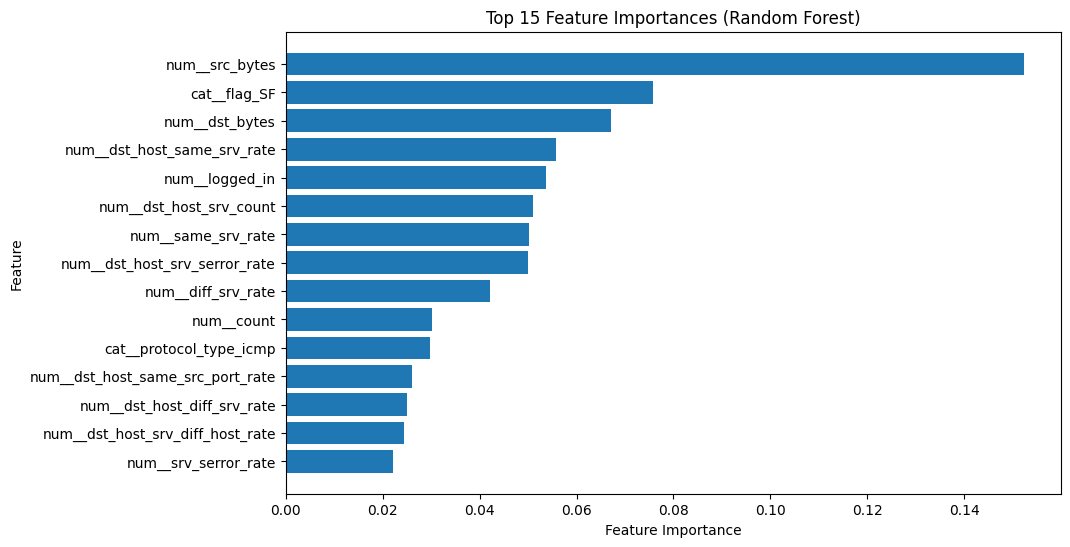

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the trained Random Forest model
rf_importances = rf.feature_importances_

# Sort indices of features by importance and select top 15
indices = np.argsort(rf_importances)[-15:]

# Create a bar chart
plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), rf_importances[indices])  # Plot the importances
plt.yticks(range(len(indices)), np.array(preprocessor.get_feature_names_out())[indices])  # Label bars with feature names
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()


## 10. ROC Curves

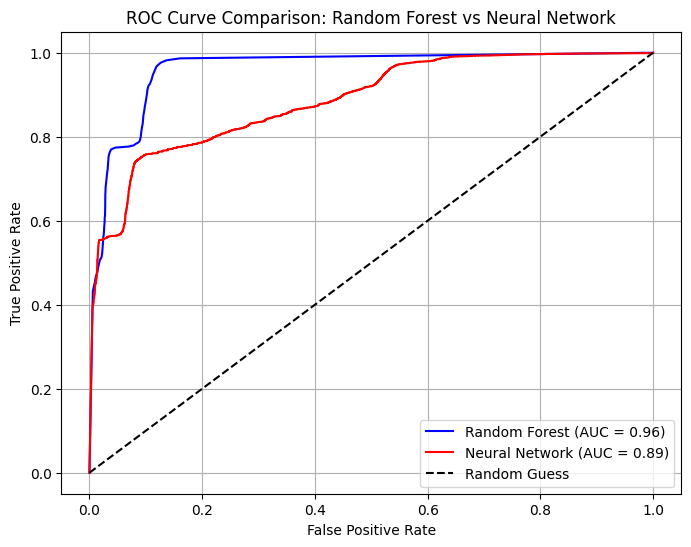

In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
rf_probs = rf.predict_proba(X_test_processed)[:, 1]
mlp_probs = mlp.predict_proba(X_test_processed)[:, 1]

# Compute ROC curve and AUC for Random Forest
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
rf_auc = auc(rf_fpr, rf_tpr)

# Compute ROC curve and AUC for Neural Network
mlp_fpr, mlp_tpr, _ = roc_curve(y_test, mlp_probs)
mlp_auc = auc(mlp_fpr, mlp_tpr)

# Plot both ROC curves in a single figure
plt.figure(figsize=(8,6))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})', color='blue')
plt.plot(mlp_fpr, mlp_tpr, label=f'Neural Network (AUC = {mlp_auc:.2f})', color='red')
plt.plot([0,1], [0,1], 'k--', label='Random Guess')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: Random Forest vs Neural Network")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## 11. Confusion Matrices

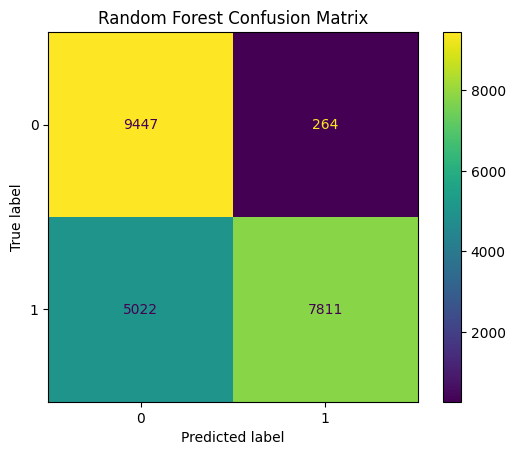

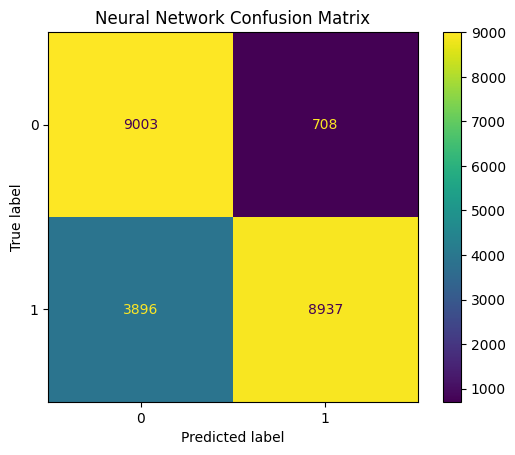

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion Matrix for Random Forest
ConfusionMatrixDisplay.from_estimator(rf, X_test_processed, y_test)
plt.title("Random Forest Confusion Matrix")
plt.show()

# Confusion Matrix for Neural Network
ConfusionMatrixDisplay.from_estimator(mlp, X_test_processed, y_test)
plt.title("Neural Network Confusion Matrix")
plt.show()
